In [896]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE

# SMOTE Models

In [858]:
# final_dataset is unbalanced
data = pd.read_csv("data/final_dataset.csv", index_col=0)
del data['Unnamed: 0.1']

In [859]:
data.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,language,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,year,artist_past_performance
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,en,0,0.388542,0.214583,0,6.225200,111,17.830752,2017,0
1,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,en,1,0.460365,0.150858,0,4.374450,420,96.012070,2005,7
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside,CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,en,0,0.611454,0.113423,0,4.051117,341,84.174322,2012,0
3,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,en,0,0.570486,-0.442188,2,3.219333,347,107.786291,2019,0
4,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,"Hold your breath, don't look down, keep trying...",70,3GNzXsFbzdwM0WKCZtgeNP,Chapters,2019-04-26,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,...,en,1,0.609292,0.232474,0,3.745333,359,95.852617,2019,0


In [860]:
# check for nan values in df
data.isna().values.any()

False

In [862]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['track_artist', 'playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
               'track_artist', 'playlist_genre', 'playlist_subgenre', 'artist_past_performance']

In [865]:
# Some of the variables are strings and need to be converted to categoricals (ints) to be machine interpretable
le = LabelEncoder()
data[categorical_columns] = data[categorical_columns].apply(le.fit_transform)

In [866]:
data.isna().values.any()

False

In [867]:
# min-max scaling of numerical features
data[numerical_columns]=(data[numerical_columns]-data[numerical_columns].min())/(data[numerical_columns].max()-data[numerical_columns].min())

In [868]:
data.isna().values.any()

False

In [869]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [870]:
len(X), len(y)

(15405, 15405)

In [871]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [873]:
def upsample(X_train, y_train):
    # Upsampling using SMOTE
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [874]:
X_train_up, y_train_up = upsample(X_train,y_train)

16372 16372


## Logistic Regression SMOTE

In [549]:
# inspecting the mutual information of features
mutual_info_classif(X_train_up, np.asarray(y_train_up).ravel() ,discrete_features='auto', n_neighbors=5, copy=True, random_state=None)

array([0.19785056, 0.18487123, 0.26189991, 0.012986  , 0.12202977,
       0.15233333, 0.07513286, 0.03837366, 0.17172445, 0.17282347,
       0.0840795 , 0.05288262, 0.0540137 , 0.18523496, 0.02921023,
       0.15366399, 0.01878114, 0.16065841, 0.01628193, 0.03804638])

#### Recursive Feature Elimination for Logistic Regression

In [555]:
logreg = LogisticRegression()
rfe = RFE(estimator=LogisticRegression(max_iter = 5000), n_features_to_select=10)
rfe = rfe.fit(X_train_up, np.asarray(y_train_up).ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False  True False  True False  True False  True
  True  True  True  True  True False False False]
[ 6  2  5  1  8  1  9  1  3  1  4  1  1  1  1  1  1 11  7 10]


In [556]:
# select the features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train_up[X_train_up.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [557]:
# inspecting the features selected
X_train_log.head()

,loudness,speechiness,instrumentalness,valence,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx
0,0.595281,0.016414,0.001345,0.131172,0.610737,0.427226,0.000000,0.421411,0.050557,0.044163
1,0.854379,0.030706,0.029363,0.268408,0.800000,0.573460,0.015267,0.269900,0.018252,0.023329
2,0.772034,0.052814,0.000006,0.116035,0.294029,0.489153,0.091603,0.505272,0.155320,0.115552
3,0.826453,0.089996,0.000005,0.631681,0.510362,0.563565,0.000000,0.467352,0.083957,0.066943
4,0.881996,0.063756,0.000000,0.396563,0.505696,0.676435,0.122137,0.393570,0.146925,0.135947


In [558]:
logreg = LogisticRegression()
logreg.fit(X_train_log, np.asarray(y_train_up).ravel())

LogisticRegression()

In [559]:
y_pred = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.59


In [560]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2059 1481]
 [ 428  654]]


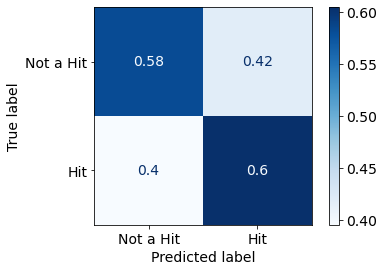

In [561]:
disp = plot_confusion_matrix(logreg, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')

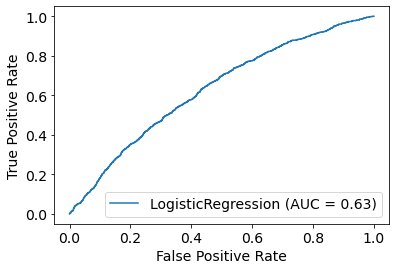

In [562]:
plot_roc_curve(logreg, X_test_log, y_test)

In [566]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001, max_iter = 5000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

GridSearchCV(estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [567]:
best_clf = clf.fit(X_train_up, np.asarray(y_train_up).ravel())
best_clf.best_estimator_

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=0.1)

In [568]:
logreg2 = LogisticRegression(C=0.1)
logreg2.fit(X_train_log, np.asarray(y_train_up).ravel())

LogisticRegression(C=0.1)

In [569]:
y_pred = logreg2.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.59


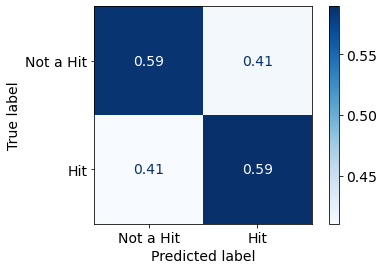

In [570]:
disp = plot_confusion_matrix(logreg2, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')

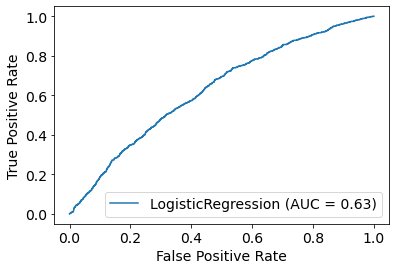

In [571]:
plot_roc_curve(logreg2, X_test_log, y_test)

## Fully Connected NN SMOTE

In [656]:
# normalize the data before feeding into a neural network
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train_up), columns=X_train_up.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [657]:
# create a validation set for the NN as Keras validation_split only selects the last x% of the data
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train_nn, y_train_up, test_size=0.3, random_state=42)

In [664]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20,)),

    keras.layers.Dense(11, activation=tf.nn.relu, kernel_initializer='normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [665]:
# running the model
opt = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=50, validation_data=(X_valid_nn, y_valid_nn))
test_loss, test_acc = model.evaluate(X_test_nn, y_test)

Epoch 1/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.5993 - val_loss: 0.6550 - val_accuracy: 0.6154
Epoch 2/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6356 - val_loss: 0.6467 - val_accuracy: 0.6232
Epoch 3/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6434 - val_loss: 0.6416 - val_accuracy: 0.6319
Epoch 4/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.6500 - val_loss: 0.6384 - val_accuracy: 0.6380
Epoch 5/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6282 - accuracy: 0.6573 - val_loss: 0.6352 - val_accuracy: 0.6441
Epoch 6/100
230/230 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.65 - 0s 1ms/step - loss: 0.6251 - accuracy: 0.6583 - val_loss: 0.6324 - val_accuracy: 0.6460
Epoch 7/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.6616

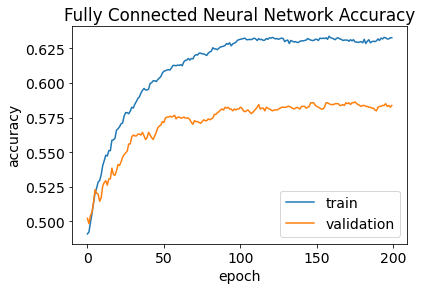

In [797]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [667]:
test_acc

0.5599307417869568

#### MLP Classifier SMOTE
Used to compare results from the neural network

In [668]:
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train_up), columns=X_train_up.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [672]:
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(15, ), activation='relu', solver='adam', 
                                             alpha=0.001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                                             max_iter=1000, shuffle=True, random_state=42, tol=0.0001, validation_fraction=0.2)
# Train the model on the whole data set
model.fit(X_train_nn, np.asarray(y_train_up).ravel())

MLPClassifier(alpha=0.001, hidden_layer_sizes=(15,), max_iter=1000,
              random_state=42, validation_fraction=0.2)

In [673]:
predictions = model.predict(X_test_nn)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

In [674]:
accuracy

0.5155776720034617

## Gradient Boosting Classifier SMOTE

In [875]:
# Establishing a baseline for model performance
clf = GradientBoostingClassifier(random_state=2, n_estimators = 100, max_features = 15, learning_rate = 0.005)
clf.fit(X_train_up, np.asarray(y_train_up).ravel())
clf.predict(X_test)
clf.score(X_test, np.asarray(y_test).ravel())

0.6274340112505409

In [683]:
# Grid Search for GBC parameters
parameters = {
    "learning_rate": [0.1],
    "min_samples_split": [10,100,500],
    "min_samples_leaf": [10,25,50,75],
    "max_depth":[5,10,15,20],
    "max_features":["log2"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[500,750,1000]
    }
# pass param grid into GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,refit=True, n_jobs=-1)

clf.fit(X_train_up, y_train_up)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 1000,
 'subsample': 1.0}

In [876]:
clfb = GradientBoostingClassifier(random_state=42, n_estimators = 1000,
                                 max_features = 'log2', learning_rate = 0.01,
                                max_depth = 20, min_samples_leaf = 10, min_samples_split = 10,
                                subsample = 1.0)

In [877]:
clfb.fit(X_train_up, np.asarray(y_train_up).ravel())
clfb.predict(X_test)
clfb.score(X_test, np.asarray(y_test).ravel())

0.7942449156209433

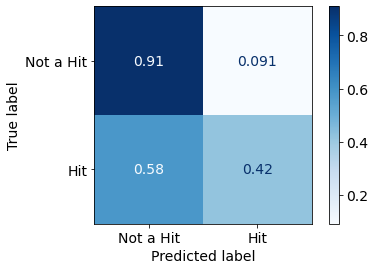

In [878]:
disp = plot_confusion_matrix(clfb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


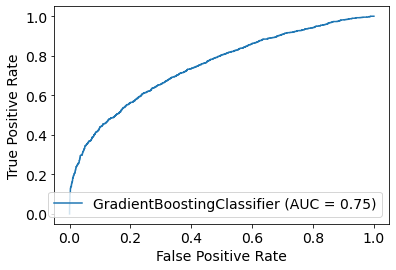

In [880]:
plot_roc_curve(clfb, X_test, y_test)

# Using Balanced non SMOTE data

In [886]:
data = pd.read_csv("data/final_subset.csv", index_col = 0)

In [895]:
data.head()

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance
1,0,3,14,0.845,0.652,-7.504,0.216,0.00432,0.007230,0.4890,...,111.904,262467,1,0.460365,0.150858,0,4.374450,420,96.012070,7
4,70,3,23,0.496,0.639,-6.157,0.055,0.28000,0.000000,0.0975,...,147.764,224720,1,0.609292,0.232474,0,3.745333,359,95.852617,0
5,52,3,14,0.764,0.594,-10.050,0.185,0.59100,0.000000,0.1450,...,87.261,286441,1,0.590514,0.200076,0,4.774017,634,132.802218,2
9,72,4,6,0.865,0.657,-6.722,0.076,0.04040,0.000000,0.1400,...,111.115,268960,1,0.409803,0.013691,3,4.482667,722,161.064842,8
11,8,3,9,0.662,0.748,-3.041,0.268,0.68800,0.000008,0.0841,...,82.331,239027,1,0.737900,0.459439,7,3.983783,554,139.063788,0


In [888]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
             'playlist_genre', 'playlist_subgenre', 'artist_past_performance']

In [889]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [698]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression

In [699]:
# Use recursive feature elimination to select features for logistic regression
rfe = RFE(estimator=LogisticRegression(max_iter = 5000), n_features_to_select=10)
rfe = rfe.fit(X_train, np.asarray(y_train).ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False  True  True  True  True  True False  True  True False
  True False False False False  True]
[1 2 3 1 1 1 1 1 9 1 1 4 1 8 6 7 5 1]


In [700]:
# select the features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train[X_train.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [701]:
# inspecting the features selected
X_train_log.head()

,danceability,speechiness,acousticness,instrumentalness,liveness,valence,lyrical_subjectivity,lyrical_polarity,minutes,artist_past_performance
1881,0.830,0.4320,0.02530,0.024800,0.1060,0.6070,0.000000,0.000000,2.570433,0
11873,0.446,0.0295,0.02980,0.000009,0.0931,0.3940,0.741493,0.330382,3.950000,0
4054,0.386,0.0489,0.00287,0.000023,0.2450,0.0858,0.516049,-0.099383,3.463500,0
9986,0.693,0.1190,0.67900,0.000000,0.2580,0.4730,0.249242,0.000758,2.034450,10
14265,0.764,0.1390,0.05440,0.000000,0.3100,0.6520,0.564947,0.065468,3.552217,2


In [702]:
logreg = LogisticRegression()
logreg.fit(X_train_log, np.asarray(y_train).ravel())

LogisticRegression()

In [703]:
y_pred = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.60


In [704]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[653 436]
 [452 667]]


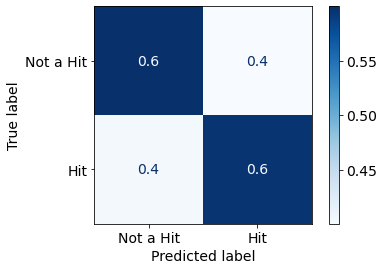

In [705]:
disp = plot_confusion_matrix(logreg, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


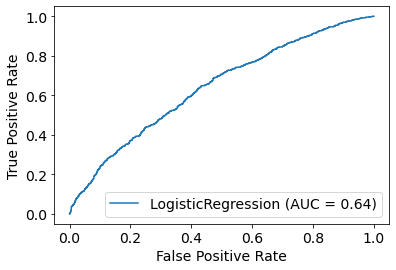

In [706]:
plot_roc_curve(logreg, X_test_log, y_test)

## Fully Connected Neural Network

In [710]:
# scale the data before passing into neural network
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [712]:
# create a validation set for the NN as Keras validation_split only selects the last x% of the data
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train_nn, y_train, test_size=0.3, random_state=42)

In [725]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(18,)),

    keras.layers.Dense(12, activation=tf.nn.relu, kernel_initializer='glorot_normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [726]:
opt = keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_nn, y_train_nn, epochs=200, batch_size=50, validation_data = (X_valid_nn, y_valid_nn))
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/200
73/73 [==============================] - 0s 3ms/step - loss: 0.7722 - accuracy: 0.4910 - val_loss: 0.7679 - val_accuracy: 0.5023
Epoch 2/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7604 - accuracy: 0.4924 - val_loss: 0.7574 - val_accuracy: 0.4984
Epoch 3/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7502 - accuracy: 0.4993 - val_loss: 0.7482 - val_accuracy: 0.5042
Epoch 4/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7413 - accuracy: 0.5057 - val_loss: 0.7403 - val_accuracy: 0.5068
Epoch 5/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.5135 - val_loss: 0.7330 - val_accuracy: 0.5139
Epoch 6/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7265 - accuracy: 0.5207 - val_loss: 0.7269 - val_accuracy: 0.5230
Epoch 7/200
73/73 [==============================] - 0s 2ms/step - loss: 0.7206 - accuracy: 0.5240 - val_loss: 0.7215 - val_accuracy: 0.5204
Epoch 8/200
7

Epoch 59/200
73/73 [==============================] - 0s 1ms/step - loss: 0.6553 - accuracy: 0.6125 - val_loss: 0.6711 - val_accuracy: 0.5741
Epoch 60/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6130 - val_loss: 0.6710 - val_accuracy: 0.5754
Epoch 61/200
73/73 [==============================] - 0s 1ms/step - loss: 0.6546 - accuracy: 0.6128 - val_loss: 0.6709 - val_accuracy: 0.5754
Epoch 62/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.6133 - val_loss: 0.6707 - val_accuracy: 0.5748
Epoch 63/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6540 - accuracy: 0.6125 - val_loss: 0.6705 - val_accuracy: 0.5748
Epoch 64/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.6153 - val_loss: 0.6705 - val_accuracy: 0.5754
Epoch 65/200
73/73 [==============================] - 0s 1ms/step - loss: 0.6534 - accuracy: 0.6164 - val_loss: 0.6704 - val_accuracy: 0.5748
Epoch 

73/73 [==============================] - 0s 2ms/step - loss: 0.6407 - accuracy: 0.6313 - val_loss: 0.6682 - val_accuracy: 0.5845
Epoch 174/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6305 - val_loss: 0.6681 - val_accuracy: 0.5858
Epoch 175/200
73/73 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6313 - val_loss: 0.6682 - val_accuracy: 0.5858
Epoch 176/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.6297 - val_loss: 0.6681 - val_accuracy: 0.5864
Epoch 177/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6297 - val_loss: 0.6682 - val_accuracy: 0.5851
Epoch 178/200
73/73 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.6294 - val_loss: 0.6682 - val_accuracy: 0.5845
Epoch 179/200
73/73 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6297 - val_loss: 0.6681 - val_accuracy: 0.5838
Epoch 180/200

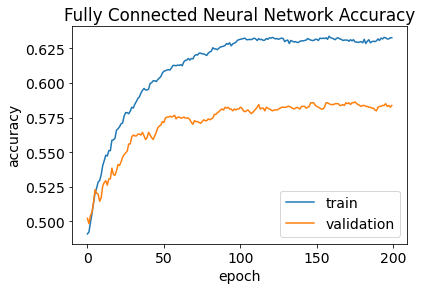

In [798]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [729]:
model.save("data/NN.h5")

In [731]:
# Load NN instead of retraining, uncomment line below
# model = tf.keras.models.load_model("data/NN.h5")

In [801]:
y_pred = model.predict(X_test_nn)

#### calculating the confusion matrix for neural network

In [838]:
y_p_ = np.where(np.asarray(y_pred)>= 0.5, 1, 0).flatten()

In [839]:
counts = Counter(zip(y_p_, y_test.to_numpy().flatten().tolist()))
tp = counts[1,1]
fp = counts[1,0]
tn = counts[0,0]
fn = counts[0,1]

In [842]:
print(tp / (tp+fn))

0.5755138516532619


In [830]:
print(tn / (tn+fp))

0.6391184573002755


In [831]:
1 - (tp / (tp+fn))

0.42448614834673815

In [832]:
1 - (tn / (tn+fp))

0.3608815426997245

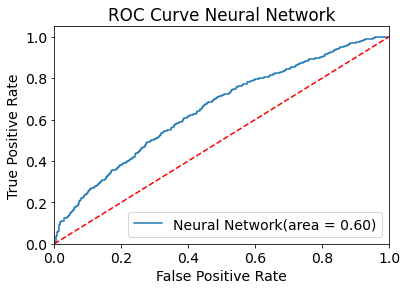

In [802]:
# ROC curve for Neural Network
nn_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Neural Network(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Neural Network')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Gradient Boosting Classifier

In [747]:
# Grid Search for GB Classifier
parameters = {
    "learning_rate": [0.01],
    "min_samples_split": [5,10,20],
    "min_samples_leaf": [2,5,10],
    "max_depth":[5,10,15],
    "max_features":["log2"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[700,900,1000]
    }
# pass param grid into GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,refit=False, n_jobs=-1)

clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 700,
 'subsample': 1.0}

In [748]:
clfb = GradientBoostingClassifier(criterion= 'friedman_mse',
                                     learning_rate= 0.01,
                                     max_depth= 15, 
                                     max_features= 'log2',
                                     min_samples_leaf= 2,
                                     min_samples_split= 5, 
                                     n_estimators= 700,
                                     subsample= 1,
                                    random_state = 42)

In [749]:
clfb.fit(X_train, np.asarray(y_train).ravel())

GradientBoostingClassifier(learning_rate=0.01, max_depth=15,
                           max_features='log2', min_samples_leaf=2,
                           min_samples_split=5, n_estimators=700,
                           random_state=42, subsample=1)

In [750]:
clfb.predict(X_test)
clfb.score(X_test, np.asarray(y_test).ravel())

0.6748188405797102

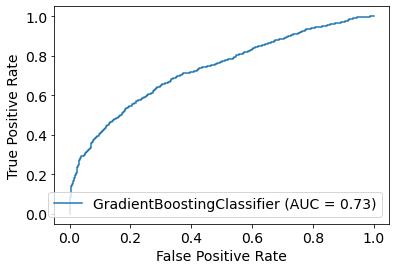

In [751]:
plot_roc_curve(clfb, X_test, y_test)

In [799]:
X_train.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,playlist_genre,playlist_subgenre,artist_past_performance
1881,0.830,0.794,-6.279,0.4320,0.02530,0.024800,0.1060,0.6070,128.160,0.000000,0.000000,3,2.570433,131,50.964169,0,1,0
11873,0.446,0.701,-4.179,0.0295,0.02980,0.000009,0.0931,0.3940,159.958,0.741493,0.330382,0,3.950000,329,83.291139,1,11,0
4054,0.386,0.708,-8.173,0.0489,0.00287,0.000023,0.2450,0.0858,110.354,0.516049,-0.099383,0,3.463500,320,92.392089,2,10,0
9986,0.693,0.497,-7.316,0.1190,0.67900,0.000000,0.2580,0.4730,81.308,0.249242,0.000758,3,2.034450,316,155.324535,5,0,10
14265,0.764,0.732,-7.232,0.1390,0.05440,0.000000,0.3100,0.6520,89.976,0.564947,0.065468,10,3.552217,560,157.648041,3,14,2


In [752]:
clfb.feature_importances_

array([0.0594815 , 0.05457487, 0.058781  , 0.08117901, 0.06220512,
       0.04527764, 0.06065024, 0.06839062, 0.06288459, 0.06030938,
       0.06846894, 0.02636196, 0.0796816 , 0.05954478, 0.05795326,
       0.02344063, 0.03750724, 0.03330762])

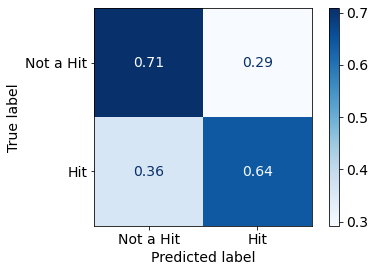

In [753]:
disp = plot_confusion_matrix(clfb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


## XGBoost

In [791]:
xgb = XGBClassifier(max_depth = 10, min_child_weight = 4, subsample = 0.8, colsample_bytree = 1
                        ,n_estimators = 1000, booster = 'gbtree', objective= 'binary:logistic'
                      ,random_state = 42, learning_rate = 0.01)
xgb.fit(X_train, np.asarray(y_train).ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [792]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [793]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.53%


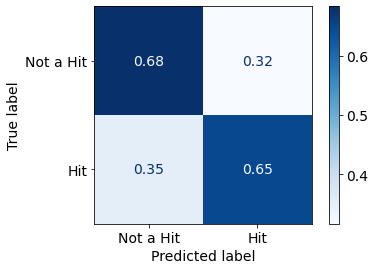

In [794]:
disp = plot_confusion_matrix(xgb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


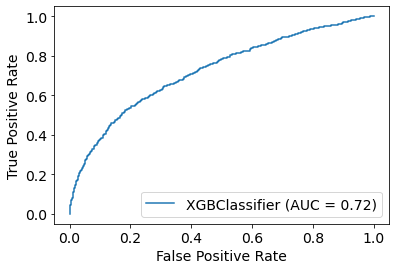

In [795]:
plot_roc_curve(xgb, X_test, y_test)